In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib as mpl
import plot_utils

In [2]:
methods = {
    # 'n_3r1i': '3 dims\n1 answer',
    # 'n_1r1i': '1 dim\n1 answer',
    'n_1r10i': '1 dim\n10 answers',
    'n_1r20i': '1 dim\n20 answers',
    'n_1r50i': '1 dim\n50 answers',
    's_1r20i': '1 dim\n20 answers\n10 samples',
    'n_1r20i_numeric': '1 dim\n20 answers\nrating-only',
    's_1r20i_numeric': '1 dim\n20 answers\nrating-only\n10 samples',
}

In [3]:
measures = ('novelty', 'feasibility', 'value')

In [4]:
pearson = pd.DataFrame(columns=measures, dtype=float)
spearman = pd.DataFrame(columns=measures, dtype=float)

In [6]:
squid = []
rmsd = []
for method, name in methods.items():
    data = pd.read_excel(f'gpt-ratings/{method}-sonnet.xlsx')
    for key in measures:
        if key == 'value':
            mask = (data[key]>0) & (data[key]<100_000)
        else:
            mask = data.index>=0
        spearman.loc[name, key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic
        pearson.loc[name, key] = stats.pearsonr(data[mask][key.capitalize()], data[mask][key]).statistic

    for qid in data['Question id'].unique():
        qmask = data['Question id'] == qid
        entry = {'method': name}
        rmsd_entry = {'method': name}
        for key in measures:
            mask = qmask
            if key == 'value':
                mask &= (data[key]>0) & (data[key]<100_000)

            entry[key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic

            x = data[mask][key.capitalize()]
            x_rank = np.empty(x.shape, int)
            x_rank[np.argsort(x)] = np.arange(len(x))

            y = data[mask][key]
            y_rank = np.empty(y.shape, int)
            y_rank[np.argsort(y)] = np.arange(len(y))

            rmsd_entry[key] = np.sqrt(np.mean(np.square(y_rank - x_rank)))

        squid.append(entry)
        rmsd.append(rmsd_entry)
spearman_qid = pd.DataFrame(squid)
rmsd = pd.DataFrame(rmsd)

Text(0, 0.5, '')

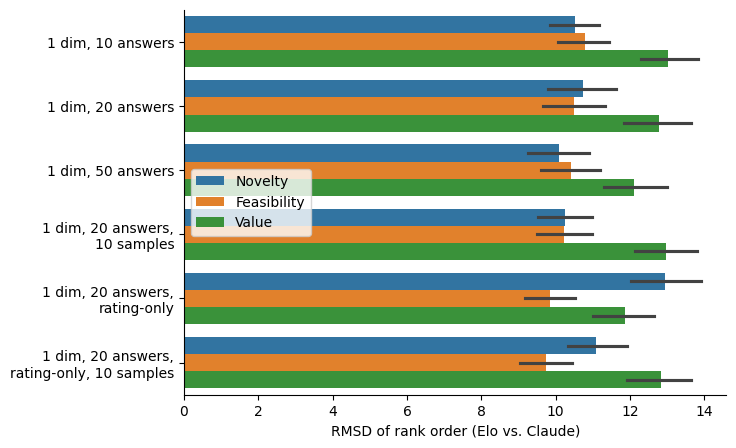

In [9]:
plt.figure(figsize=(7,5))
long = rmsd.set_index('method').melt(value_name='RMSD of rank order (Elo vs. Claude)', var_name='measure', ignore_index=False)
long.index = [s.replace('\n',', ').replace('answers, ','answers,\n') for s in long.index]
ax = sns.barplot(long, y=long.index, x='RMSD of rank order (Elo vs. Claude)', hue='measure')
plt.legend(ax.containers, [m.capitalize() for m in measures], loc='center left')
sns.despine()
plt.ylabel('')

In [8]:
pearson

,novelty,feasibility,value
1 dim\n10 answers,0.599327,0.557792,0.244494
1 dim\n20 answers,0.573455,0.564938,0.220518
1 dim\n50 answers,0.604290,0.550683,0.236519
1 dim\n20 answers\n10 samples,0.581920,0.585675,0.113451
1 dim\n20 answers\nrating-only,0.377289,0.654708,0.241823
1 dim\n20 answers\nrating-only\n10 samples,0.509419,0.658418,0.412866


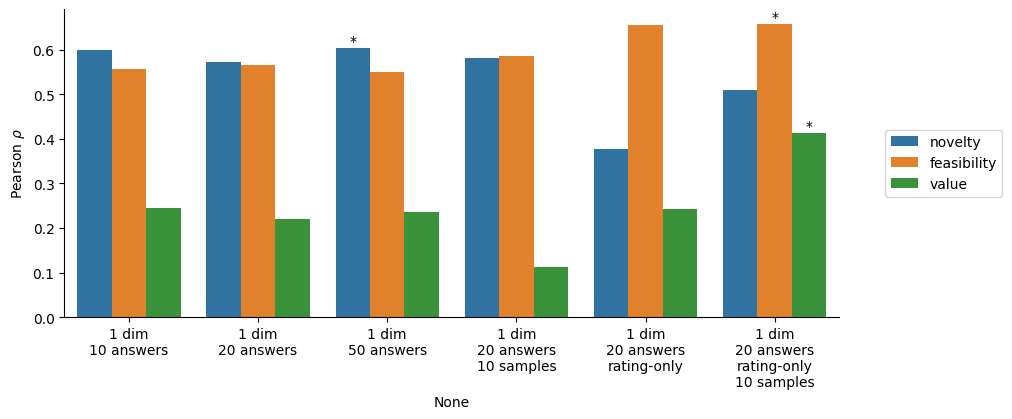

In [10]:
fig, ax = plt.subplots(figsize=(10,4))

long = pearson.melt(value_name='correlation', var_name='measure', ignore_index=False)

imax = [i*len(pearson) + pearson[col].astype('float').argmax() for i, col in enumerate(pearson.columns)]
labels = ['*' if i in imax else '' for i in range(len(long))]

sns.barplot(long, x=long.index, y='correlation', hue='measure', ax=ax)
for i, col in enumerate(pearson.columns):
    jmax = pearson[col].astype('float').argmax()
    labels = ['*' if j == jmax else '' for j in range(len(pearson))]
    ax.bar_label(ax.containers[i], labels)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
ax.set_ylabel('Pearson $\\rho$')
sns.despine(ax=ax)


In [11]:
spearman

,novelty,feasibility,value
1 dim\n10 answers,0.591489,0.564552,0.303352
1 dim\n20 answers,0.568540,0.581001,0.289469
1 dim\n50 answers,0.602179,0.572215,0.302096
1 dim\n20 answers\n10 samples,0.600696,0.599083,0.219471
1 dim\n20 answers\nrating-only,0.368546,0.639303,0.399755
1 dim\n20 answers\nrating-only\n10 samples,0.527052,0.645980,0.391996


In [12]:
mean = spearman_qid.groupby('method').mean()

In [13]:
std = spearman_qid.groupby('method').std()

In [14]:
print('\t'.join(['Method'] + [m.capitalize() for m in measures]))
for method in methods.values():
    m = method.replace('\n', ', ')
    print(m, end='')
    for measure in measures:
        mean_, sd_ = mean.loc[method, measure], std.loc[method, measure]
        print(f'\t{mean_:.2f}\t{sd_:.2f}\t{mean_/sd_:.2f}', end='')
    print()

Method	Novelty	Feasibility	Value
1 dim, 10 answers	0.59	0.11	5.54	0.57	0.13	4.41	0.36	0.14	2.46
1 dim, 20 answers	0.58	0.16	3.71	0.59	0.16	3.58	0.36	0.18	2.00
1 dim, 50 answers	0.62	0.15	4.26	0.60	0.13	4.61	0.43	0.17	2.44
1 dim, 20 answers, 10 samples	0.61	0.13	4.56	0.61	0.15	4.08	0.37	0.18	2.06
1 dim, 20 answers, rating-only	0.37	0.25	1.48	0.64	0.11	5.79	0.45	0.16	2.81
1 dim, 20 answers, rating-only, 10 samples	0.54	0.19	2.85	0.65	0.14	4.75	0.40	0.16	2.52
